In [1]:
%%bash
uenv cudnn-11.x-8.7.0 verbose
uenv cuda-11.8.0 verbose

A GPU-accelerated library of primitives for deep neural networks, https://developer.nvidia.com/cudnn
prepending to __UENV: cudnn-11.x-8.7.0
prepending to LD_LIBRARY_PATH: /usr/local/_cuda/cudnn-11.x-8.7.0/lib


CUDA is a parallel computing platform for computing on GPUs, https://developer.nvidia.com/cuda-toolkit
prepending to __UENV: cuda-11.8.0
setting env CUDA_HOME=/usr/local/_cuda/cuda-11.8.0_ubuntu22
setting env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/_cuda/cuda-11.8.0_ubuntu22
prepending to PATH: /usr/local/_cuda/cuda-11.8.0_ubuntu22/bin
prepending to LD_LIBRARY_PATH: /usr/local/_cuda/cuda-11.8.0_ubuntu22/lib64




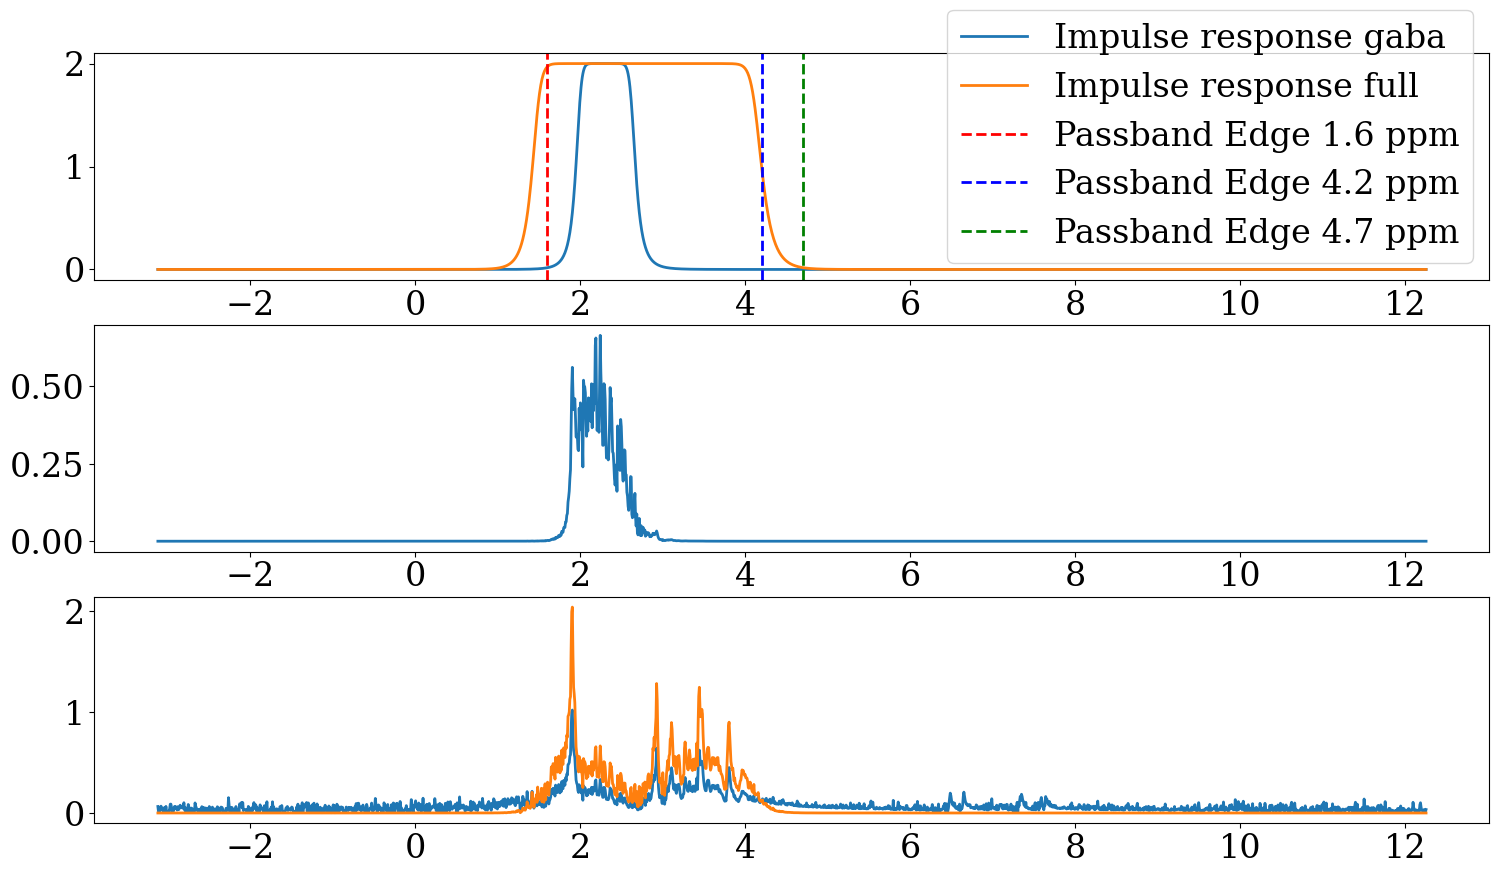

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
from myfunctions_tf import BPF_ppm
path = "/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/train_2/TE20_lw03_0003_data.npz"
ppm = np.linspace(-3.121, 12.258, 2048)
plt.figure()

data = np.load(path)
plt.subplot(311)
plt.plot(ppm, data["filter_impulse_response_GABA"].__abs__(), label="Impulse response gaba")
plt.plot(ppm, data["filter_impulse_response_full"].__abs__(), label="Impulse response full")
plt.axvline(x=1.6, color='red', linestyle='--', label='Passband Edge 1.6 ppm')
plt.axvline(x=4.2, color='blue', linestyle='--', label='Passband Edge 4.2 ppm')
plt.axvline(x=4.7, color='green', linestyle='--', label='Passband Edge 4.7 ppm')
plt.legend()
plt.subplot(312)
plt.plot(ppm, data["fft_filtered_GABA"].__abs__(), label="GABA")

plt.subplot(313)
plt.plot(ppm, data["augmented"].__abs__(), label="Full")
plt.plot(ppm, data["fft_filtered_full"].__abs__(), label="Full")
                
#.gca().invert_xaxis()
plt.show()

Loaded input shape: (200, 2048, 2), Loaded output shape: (200, 2048, 10)
(200, 2048, 2)


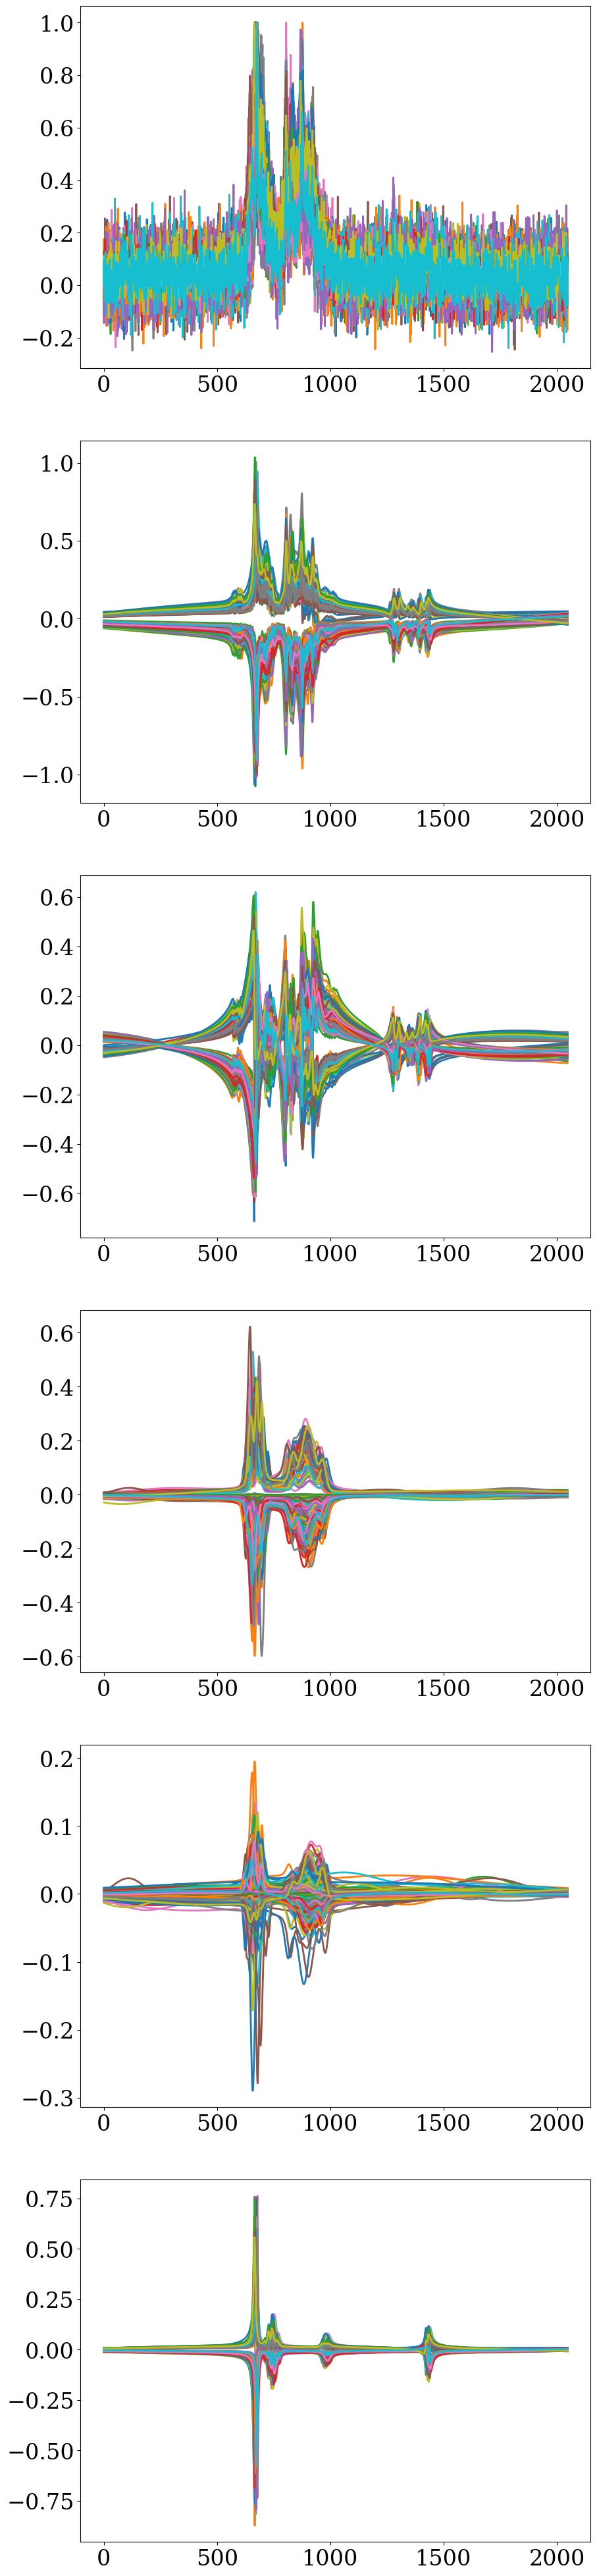

In [29]:
from myfunctions_tf import load_from_directory
import matplotlib.pyplot as plt
import scipy.fft as sf
path = "/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/val"
input_data, output_data = load_from_directory(path, num_signals=200, input_keys = ["augmented_ifft"], output_keys = ["original", "baseline", "NAA", "NAAG", "Cr"])
print(input_data.shape)
plt.figure(figsize=(10, 50))
for i in range(200):
    plt.subplot(6,1,1)
    plt.plot(sf.fftshift(sf.fft(input_data[i,:,0]+ input_data[i,:,1]*1j)).real, label="Augmented")
for k in range(5):
    plt.subplot(6,1,k+2)
    for i in range(200):
        plt.plot(output_data[i,:,k], label="Original")
plt.show()

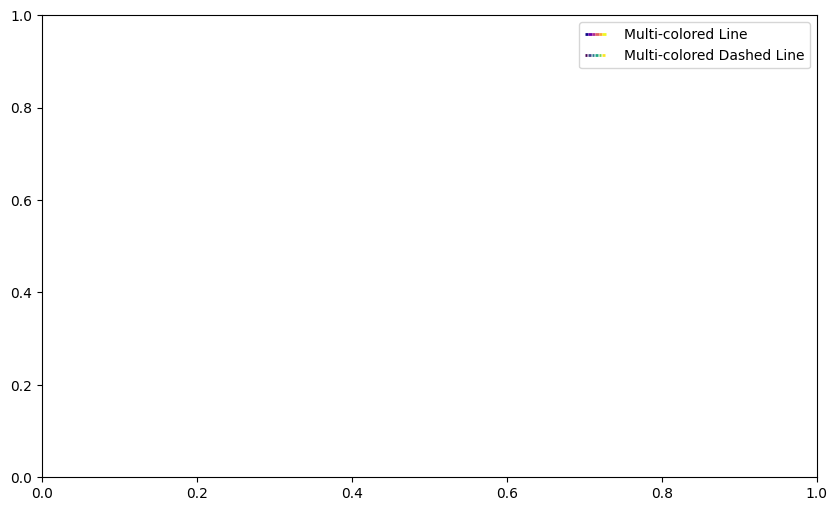

In [6]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection
import numpy as np
from matplotlib import cm

class MultiColorLine:
    """
    A class to create a multicolored line and its corresponding legend entry.
    """
    def __init__(self, x, y, colormap='viridis', linestyle='solid', linewidth=2):
        """
        Initialize the multicolored line.

        Args:
            x (array-like): The x-coordinates of the line.
            y (array-like): The y-coordinates of the line.
            colormap (str): The name of the colormap to use.
            linestyle (str): The line style ('solid' or 'dashed').
            linewidth (float): The width of the line.
        """
        self.x = x
        self.y = y
        self.colormap = plt.get_cmap(colormap)
        self.linestyle = linestyle
        self.linewidth = linewidth
        self.line_collection = self._create_line_collection()

    def _create_line_collection(self):
        """
        Create the multicolored line as a LineCollection.

        Returns:
            LineCollection: The multicolored line.
        """
        # Create segments for the line
        segments = [((self.x[i], self.y[i]), (self.x[i + 1], self.y[i + 1])) for i in range(len(self.x) - 1)]
        # Create the LineCollection with the colormap
        line_collection = LineCollection(segments, cmap=self.colormap, linewidths=self.linewidth)
        line_collection.set_array(np.linspace(0, 1, len(segments)))  # Map colors to segments
        
        # In MultiColorLine._create_line_collection
        if self.linestyle == 'dashed':
            line_collection.set_linestyle((0, (5, 5)))  # Dashed pattern
        
        return line_collection

    def add_to_axes(self, ax):
        """
        Add the multicolored line to the given axes.

        Args:
            ax: The Matplotlib axes to add the line to.
        """
        ax.add_collection(self.line_collection)

    def get_handler(self, num_segments=9):
        """
        Get a custom legend handler for the multicolored line.

        Args:
            num_segments (int): The number of segments to display in the legend.

        Returns:
            MultiColorLegendHandler: The custom legend handler.
        """
        return MultiColorLegendHandler(colormap=self.colormap.name, num_segments=num_segments, linestyle=self.linestyle)


class MultiColorLegendHandler(HandlerLineCollection):
    """
    A custom legend handler for multicolored lines, supporting dashed or solid styles.
    """
    def __init__(self, colormap='viridis', num_segments=9, linestyle='solid'):
        super().__init__()
        self.colormap = plt.get_cmap(colormap)
        self.num_segments = num_segments
        self.linestyle = linestyle

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height

        segment_width = width / (self.num_segments + 2)
        segments = []
        colors = []

        sampled_colors = [self.colormap(i / (self.num_segments - 1)) for i in range(self.num_segments)]

        for i in range(self.num_segments):
            start_x = x0 + i * segment_width
            if self.linestyle == 'dashed':
                # Create a gap to simulate a dashed line
                end_x = start_x + segment_width * 0.7
            else:
                end_x = start_x + segment_width
            segments.append([[start_x, y0 + height / 2], [end_x, y0 + height / 2]])
            colors.append(sampled_colors[i])

        lc = LineCollection(segments, colors=colors, linewidths=2)
        lc.set_transform(handlebox.get_transform())
        handlebox.add_artist(lc)

        return lc


# Example usage
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

fig, ax = plt.subplots(figsize=(10, 6))

# Create a multicolored solid line
multicolor_line_solid = MultiColorLine(np.zeros(1), np.zeros(1), colormap='plasma', linestyle='solid')
multicolor_line_solid.add_to_axes(ax)

# Create a multicolored dashed line
multicolor_line_dashed = MultiColorLine(np.zeros(1), np.zeros(1), colormap='viridis', linestyle='dashed')
multicolor_line_dashed.add_to_axes(ax)

# Add other lines
#line1, = ax.plot(x, y1, color='black', label='Sine Wave', linestyle='--')
#line2, = ax.plot(x, y2, color='purple', label='Cosine Wave')

# Add legend
handles = [
    multicolor_line_solid.line_collection,

    multicolor_line_dashed.line_collection
]
labels = [
    'Multi-colored Line',

    'Multi-colored Dashed Line'
]
ax.legend(
    handles,
    labels,
    handler_map={
        LineCollection: multicolor_line_solid.get_handler(num_segments=6),
        multicolor_line_dashed.line_collection: multicolor_line_dashed.get_handler(num_segments=6)
    }
)

plt.show()

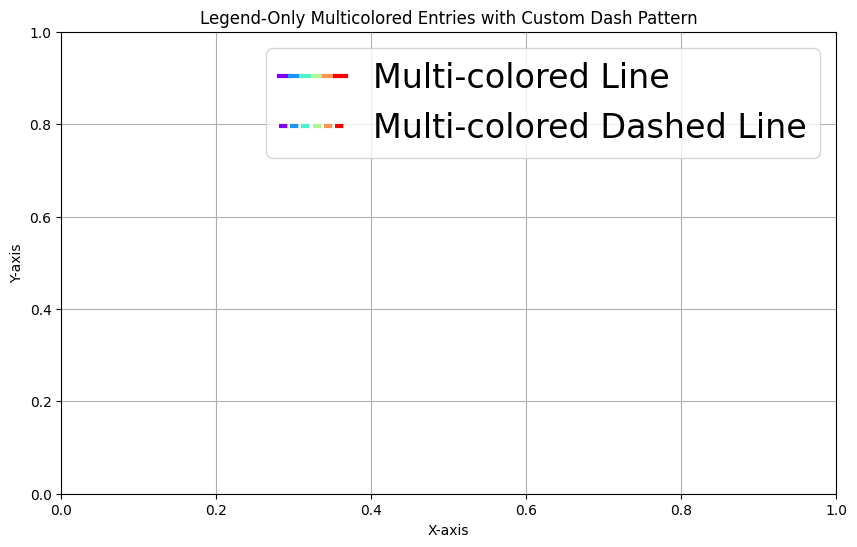

In [1]:
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

class MultiColorLegendHandler(HandlerBase):
    """
    A custom legend handler for multicolored lines in the legend.
    """
    def __init__(self, colormap='viridis', num_segments=9, linestyle='-', linewidth=2):
        super().__init__()
        self.colormap = plt.get_cmap(colormap)
        self.num_segments = num_segments
        self.linestyle = linestyle
        self.linewidth = linewidth

    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        segment_width = width / self.num_segments
        segments = []
        colors = [self.colormap(i / (self.num_segments - 1)) for i in range(self.num_segments)]

        for i in range(self.num_segments):
            start_x = x0 + i * segment_width
            end_x = start_x + segment_width
            # Create each segment with the specified linestyle
            segments.append(Line2D(
                [start_x, end_x], 
                [y0 + height / 2, y0 + height / 2],
                color=colors[i],
                linestyle=self.linestyle,  # Use Matplotlib's terminology for line styles
                linewidth=self.linewidth,
                transform=trans
            ))
        return segments


# Create a figure and a subplot
plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)  # Single subplot

# Create dummy handles for the legend
handles = [
    Line2D([], [], label='Multi-colored Line'),
    Line2D([], [], label='Multi-colored Dashed Line')
]

# Add legend with custom handlers
plt.legend(
    handles=handles,
    handler_map={
        handles[0]: MultiColorLegendHandler(colormap='rainbow', num_segments=6, linestyle='-', linewidth=3),
        handles[1]: MultiColorLegendHandler(colormap='rainbow', num_segments=6, linestyle=(1, (3, 4)), linewidth=3)  # Custom dash pattern
    },
    fontsize=24,
    loc='upper right'
)

# Customize the plot
plt.title("Legend-Only Multicolored Entries with Custom Dash Pattern")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)

# Show the plot
plt.show()

(532,)
freq from: 47 - 131
freq: ['0.235127', '0.230350', '0.225574', '0.220797', '0.216020', '0.211243', '0.206466', '0.201689', '0.196912']
839 839 839 839


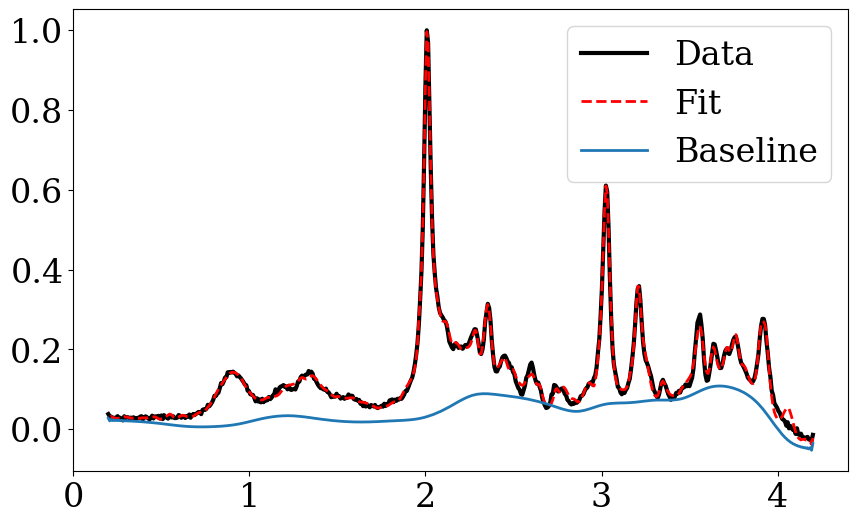

In [ ]:
import scipy.signal
from myfunctions_tf import read_LCModel_coord
import numpy as np
import matplotlib.pyplot as plt
import scipy

path = "/home/stud/casperc/bhome/Project3_DL_sigpros/in_vivo_data/lcmodel/G1_P/S03/coord"
path_synth = "/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/train_2/TE20_lw03_0002_data.npz"
data_synth = np.load(path_synth)
ppm = np.linspace(-3.121, 12.258, 2048)
ppm_crop = np.where((ppm >= 0.2) & (ppm <= 4.2))
print(data_synth["augmented"][ppm_crop].shape)
freq, data, fit, baseline = read_LCModel_coord(path)
print(len(freq), len(data), len(fit), len(baseline))
data = scipy.signal.resample(data, 532)
fit = scipy.signal.resample(fit, 532)
baseline = scipy.signal.resample(baseline, 532)
freq = np.linspace(4.2, 0.2, 532)
plt.figure(figsize=(10, 6))
plt.plot(freq, data.real[:]/np.max(data), label="Data",linewidth=3, color='black')
plt.plot(freq, fit.real[:]/np.max(data), label="Fit",linewidth=2, linestyle='--', color="red")
plt.plot(freq, baseline.real[:]/np.max(data), label="Baseline")
plt.legend()
plt.show()
print(sum([len(os.listdir(os.path.join(os.getcwd(), folder)))/4 for folder in P]))

In [2]:
from myfunctions_tf import read_LCModel_coord
import numpy as np
import matplotlib.pyplot as plt
import os
path = "/home/stud/casperc/bhome/Project3_DL_sigpros/in_vivo_data/Osprey/LCModelFiles/metabs/dat_files_G4_P_S01_PRESS_35_LCM_A.RAW"
real_sig, imag_sig = read_LCModel_coord(path)
plt.plot(real_sig, label="Real part",linewidth=2, color='black')
plt.show()
""" ppm = np.linspace(4.7-39.1/2, 4.7+39.1/2, len(sig))
print(ppm[np.where(freq.real == freq.real.max())]) """

""" plt.subplot(211)
plt.plot(sig, label="Data",linewidth=2, color='black')
plt.legend()
plt.subplot(212)
plt.plot(ppm, freq, label="Frequency",linewidth=2, color='black')
plt.axvline(x=2.02, color='green', linestyle='--', label='2.02 ppm')
plt.legend()
plt.legend()
plt.show() """

FileNotFoundError: [Errno 2] No such file or directory: '/home/stud/casperc/bhome/Project3_DL_sigpros/in_vivo_data/Osprey/LCModelFiles/metabs/dat_files_G4_P_S01_PRESS_35_LCM_A.RAW'

{'NAA': {'conc': 24.448, '%SD': 2.0, '/Cr+PCr': 1.283}, 'GABA': {'conc': 0.153, '%SD': 571.0, '/Cr+PCr': 0.008}, 'Glu': {'conc': 26.843, '%SD': 6.0, '/Cr+PCr': 1.408}, 'Gln': {'conc': 26.843, '%SD': 6.0, '/Cr+PCr': 1.408}, 'Cr+PCr': {'conc': 19.062, '%SD': 2.0, '/Cr+PCr': 1.0}}
freq from: 43 - 127
freq: ['0.233391', '0.228612', '0.223833', '0.219054', '0.214275', '0.209496', '0.204717', '0.199937']


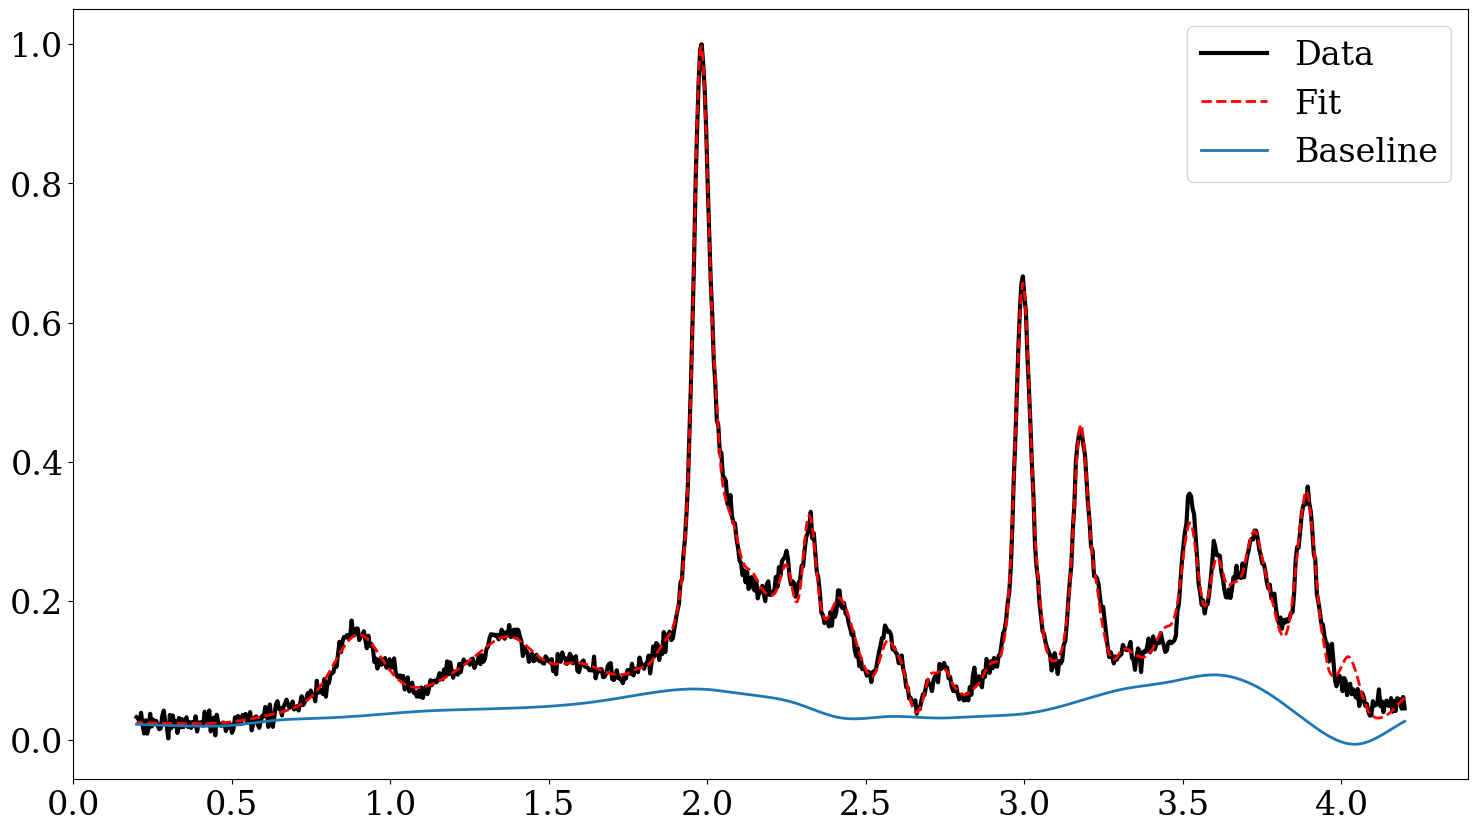

In [7]:
import numpy as np
from myfunctions_tf import read_LCModel_table, read_LCModel_coord
import matplotlib.pyplot as plt

path = "/home/stud/casperc/bhome/Project3_DL_sigpros/in_vivo_data/correlation_analysis/G1_P/S01.table"
path_coord = "/home/stud/casperc/bhome/Project3_DL_sigpros/in_vivo_data/Osprey/GE/LCMoutput/LCModelFiles_metabs_dat_files_G4_P_S01_PRESS_35_LCM_A.coord"
data = read_LCModel_table(path, ["NAA", "GABA", "Glu", "Gln", "Cr+PCr"])
print(data)

freq, data, fit, baseline = read_LCModel_coord(path_coord)
plt.figure()
plt.plot(freq, data.real[:]/np.max(data), label="Data",linewidth=3, color='black')
plt.plot(freq, fit.real[:]/np.max(data), label="Fit",linewidth=2, linestyle='--', color="red")
plt.plot(freq, baseline.real[:]/np.max(data), label="Baseline")
plt.legend()
plt.show()

In [11]:
import os
from myfunctions_tf import read_LCModel_table

# Define the path to the correlation analysis directory
correlation_analysis_path = "/home/stud/casperc/bhome/Project3_DL_sigpros/in_vivo_data/correlation_analysis"

# Initialize lists to store folder/subject names
glu_greater_naa = []
gln_greater_naa = []
glu_plus_gln_greater_naa = []

# Iterate through folders and files in the correlation analysis directory
for root, _, files in os.walk(correlation_analysis_path):
    for file in files:
        if file.endswith(".table"):
            # Construct the full file path
            file_path = os.path.join(root, file)
            
            # Read the .table file
            data = read_LCModel_table(file_path, ["NAA", "Glu", "Gln", "Glu+Gln"])
            
            # Perform the comparisons and append folder/subject names
            folder_subject = os.path.basename(root) + "/" + file
            if data["Glu"]["/Cr+PCr"] > data["NAA"]["/Cr+PCr"]:
                glu_greater_naa.append(folder_subject)
            if data["Gln"]["/Cr+PCr"] > data["NAA"]["/Cr+PCr"]:
                gln_greater_naa.append(folder_subject)
            if (data["Glu+Gln"]["/Cr+PCr"]) > data["NAA"]["/Cr+PCr"]:
                glu_plus_gln_greater_naa.append(folder_subject)

# Print the results
print(f"Number of files with Glu > NAA: {len(glu_greater_naa)}")
print(f"Number of files with Gln > NAA: {len(gln_greater_naa)}")
print(f"Number of files with Glu + Gln > NAA: {len(glu_plus_gln_greater_naa)}")

# Optionally, print the lists
print("Files with Glu > NAA:", glu_greater_naa)
print("Files with Gln > NAA:", gln_greater_naa)
print("Files with Glu + Gln > NAA:", glu_plus_gln_greater_naa)

Number of files with Glu > NAA: 105
Number of files with Gln > NAA: 105
Number of files with Glu + Gln > NAA: 105
Files with Glu > NAA: ['G6_P/S05.table', 'G6_P/S09.table', 'G6_P/S04.table', 'G6_P/S08.table', 'G6_P/S12.table', 'G6_P/S07.table', 'G6_P/S11.table', 'G6_P/S06.table', 'G6_P/S10.table', 'G6_P/S01.table', 'G6_P/S03.table', 'G6_P/S02.table', 'P6_P/S06.table', 'P6_P/S10.table', 'P6_P/S07.table', 'P6_P/S11.table', 'P6_P/S04.table', 'P6_P/S08.table', 'P6_P/S12.table', 'P6_P/S05.table', 'P6_P/S09.table', 'P6_P/S02.table', 'P6_P/S03.table', 'P6_P/S01.table', 'P7_P/S07.table', 'P7_P/S08.table', 'P7_P/S09.table', 'P7_P/S02.table', 'P7_P/S01.table', 'G7_P/S03.table', 'G7_P/S06.table', 'G7_P/S10.table', 'G7_P/S11.table', 'P10_P/S07.table', 'P10_P/S10.table', 'P10_P/S06.table', 'P10_P/S05.table', 'P10_P/S09.table', 'P10_P/S12.table', 'P10_P/S04.table', 'P10_P/S03.table', 'P10_P/S02.table', 'P10_P/S01.table', 'fmrs_pain/S11.table', 'fmrs_pain/S07.table', 'fmrs_pain/S10.table', 'fmrs_pain

NAA: 24.31778258105807
Glu: 14.502840287641035
Gln: 8.84660276721477
scaled_NAA: 21.08577606163263
scaled_Glu: 22.41750928657782
scaled_Gln: 3.625273779017542


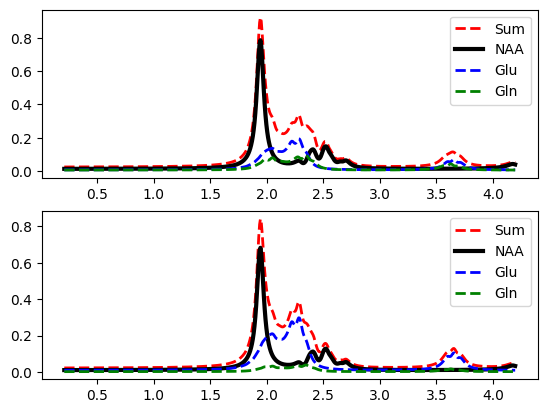

In [2]:
import numpy as np
import matplotlib.pyplot as plt
path ="/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/train_2/TE30_lw10_0171_data.npz"
data_synth = np.load(path)
ppm = np.linspace(-3.121, 12.258, 2048)
ppm_crop = np.where((ppm >= 0.2) & (ppm <= 4.2))
ppm = ppm[ppm_crop]
NAA = data_synth["NAA"][ppm_crop].real
tCr = data_synth["Cr"][ppm_crop].real + data_synth["PCr"][ppm_crop].real
Glu = data_synth["Glu"][ppm_crop].real
Gln = data_synth["Gln"][ppm_crop].real

rNAA = NAA/np.sum(tCr)
rGlu = Glu/np.sum(tCr)
rGln = Gln/np.sum(tCr)

scaled_NAA = NAA / sum(NAA) * 1.14
scaled_Glu = Glu / sum(Glu) * 1.212
scaled_Gln = Gln / sum(Gln) * 0.196
scaling_factor = np.max((scaled_NAA+scaled_Gln+scaled_Glu.max()))
scaled_NAA = scaled_NAA / scaling_factor
scaled_Glu = scaled_Glu / scaling_factor
scaled_Gln = scaled_Gln / scaling_factor
rNAA = rNAA / scaling_factor
rGlu = rGlu / scaling_factor
rGln = rGln / scaling_factor

print(f"NAA: {np.sum(rNAA)}")
print(f"Glu: {np.sum(rGlu)}")
print(f"Gln: {np.sum(rGln)}")
print(f"scaled_NAA: {np.sum(scaled_NAA)}") 
print(f"scaled_Glu: {np.sum(scaled_Glu)}")
print(f"scaled_Gln: {np.sum(scaled_Gln)}")
plt.figure()
plt.subplot(2,1,1)
plt.plot(ppm, rNAA+rGlu+rGln, label="Sum",linewidth=2, linestyle='--', color="red")
plt.plot(ppm, rNAA, label="NAA",linewidth=3, color='black')
#plt.plot(ppm, tCr, label="tCr",linewidth=2, linestyle='--', color="red")
plt.plot(ppm, rGlu, label="Glu",linewidth=2, linestyle='--', color="blue")
plt.plot(ppm, rGln, label="Gln",linewidth=2, linestyle='--', color="green")
plt.legend()

plt.subplot(2,1,2)
plt.plot(ppm, scaled_NAA+scaled_Glu+scaled_Gln, label="Sum",linewidth=2, linestyle='--', color="red")
plt.plot(ppm, scaled_NAA, label="NAA",linewidth=3, color='black')
plt.plot(ppm, scaled_Glu, label="Glu",linewidth=2, linestyle='--', color="blue")
plt.plot(ppm, scaled_Gln, label="Gln",linewidth=2, linestyle='--', color="green")
plt.legend()
plt.show()

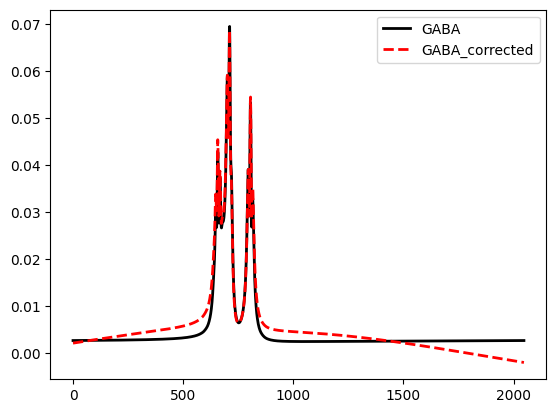

In [13]:
import numpy as np
from scipy.optimize import minimize_scalar, minimize
import time
import matplotlib.pyplot as plt

""" def first_order_phase_correct(spectrum):
    
    #Applies zero- and first-order phase correction to a complex spectrum.
    #Returns the corrected real spectrum and the phase parameters.

    n = spectrum.size
    freqs = np.linspace(-0.5, 0.5, n)  # Normalized frequency axis

    def cost(params):
        phi0, phi1 = params
        phase = phi0 + phi1 * freqs
        corrected = spectrum * np.exp(-1j * phase)
        return np.sum(np.abs(corrected.imag))

    res = minimize(cost, [0, 0], bounds=[(-np.pi, np.pi), (-np.pi, np.pi)])
    phi0, phi1 = res.x
    phase = phi0 + phi1 * freqs
    corrected_spectrum = spectrum * np.exp(-1j * phase)
    return corrected_spectrum, (phi0, phi1) """


def first_order_phase_correct(spectrum):
    """
    Applies zero- and first-order phase correction to a complex spectrum.
    Returns the corrected real spectrum and the phase component.
    """
    n = spectrum.size
    freqs = np.linspace(-0.5, 0.5, n)  # Normalized frequency axis

    def cost(params):
        phi0, phi1 = params
        phase = phi0 + phi1 * freqs
        corrected = spectrum * np.exp(-1j * phase)
        return np.sum(np.abs(corrected.imag))

    res = minimize(cost, [0, 0], bounds=[(-np.pi, np.pi), (-np.pi, np.pi)])
    phi0, phi1 = res.x
    phase = phi0 + phi1 * freqs
    corrected_spectrum = spectrum * np.exp(-1j * phase)
    return corrected_spectrum, np.exp(-1j * phase)

data = np.load("/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/train_2/TE30_lw10_0171_data.npz")
ppm = np.linspace(-3.121, 12.258, 2048)
first_order_phase_corrected, phase = first_order_phase_correct(data["augmented"])
plt.figure()
""" plt.subplot(211)
plt.plot(ppm, data["augmented"].real, label="Original",linewidth=1, color='black')
plt.plot(ppm, first_order_phase_corrected.real, label="First Order Corrected",linewidth=1, linestyle='--', color="green")
plt.legend()
plt.subplot(212) """
plt.plot(data["GABA"].real, label="GABA",linewidth=2, color='black')
plt.plot( (data["GABA"]*phase).real, label="GABA_corrected",linewidth=2, color='red', linestyle='--')
plt.legend()
plt.show()

In [2]:
data = np.load("/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/train_2/TE30_lw10_0171_data.npz")
NAA = data["NAA"]
NAA_FID = data["NAA_ifft"]
NAA_FID_fft = np.fft.fftshift(np.fft.fft(NAA_FID))
NAA_ifft = np.fft.ifft(np.fft.fftshift(NAA))

plt.figure()
plt.subplot(311)
plt.plot(NAA_ifft.real, label="Original",linewidth=1, color='black')
plt.plot(NAA_FID.real, label="NAA FID",linewidth=1, linestyle='--', color="green")
plt.legend()
plt.subplot(312)
plt.plot(NAA_ifft.real-NAA_FID.real, label="Original",linewidth=1, color='black')
plt.subplot(313)
plt.plot(NAA, label="Original",linewidth=1, color='black')
plt.plot(NAA_FID_fft.real, label="NAA FID FFT",linewidth=1, linestyle='--', color="green")
plt.legend()
plt.show()


NameError: name 'np' is not defined

In [1]:
import numpy as np
data_path = "/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/train_2/TE20_lw03_0005_data.npz"
data = np.load(data_path)
for key in data.keys():
    print(key)
    

original
augmented
baseline
metadata
augmented_ifft
a
b
original_ifft
iir_order
filter_impulse_response_GABA
filter_impulse_response_full
filtered_GABA
filtered_full
fft_filtered_GABA
fft_filtered_full
GSH
GPC
Glc
NAAG
NAA
Tau
PCho
Gly
mI
Ala
GABA
Lac
PCr
Glu
Cr
Gln
GSH_ifft
GPC_ifft
Glc_ifft
NAAG_ifft
NAA_ifft
Tau_ifft
PCho_ifft
Gly_ifft
mI_ifft
Ala_ifft
GABA_ifft
Lac_ifft
PCr_ifft
Glu_ifft
Cr_ifft
Gln_ifft


2025-06-20 13:23:54.649297: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-20 13:23:54.649362: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-20 13:23:54.651441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-20 13:23:54.842527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


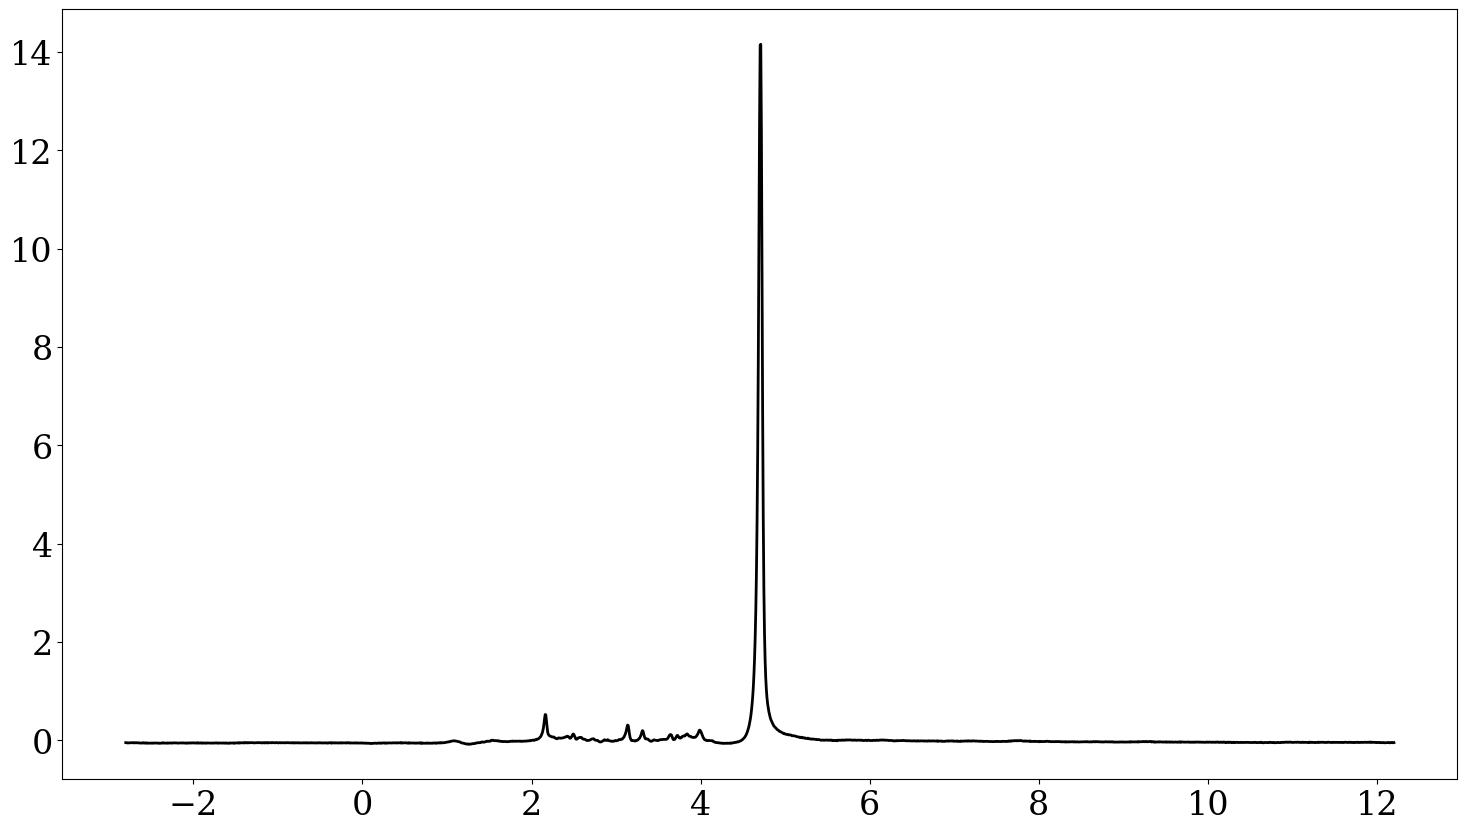

In [1]:
from myfunctions_tf import load_mrui_txt_data
import matplotlib.pyplot as plt
import numpy as np
path = "/home/stud/casperc/bhome/Project3_DL_sigpros/in_vivo_data/mrui_files/P9_P/S01.txt"
times, freq, meta = load_mrui_txt_data(path)
ppm = np.linspace(4.7-15/2, 4.7+15/2, len(freq))
plt.figure()
plt.plot(ppm, freq.real,linewidth=2, color='black')
plt.show()

Loaded input shape: (0,), Loaded output shape: (0,)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

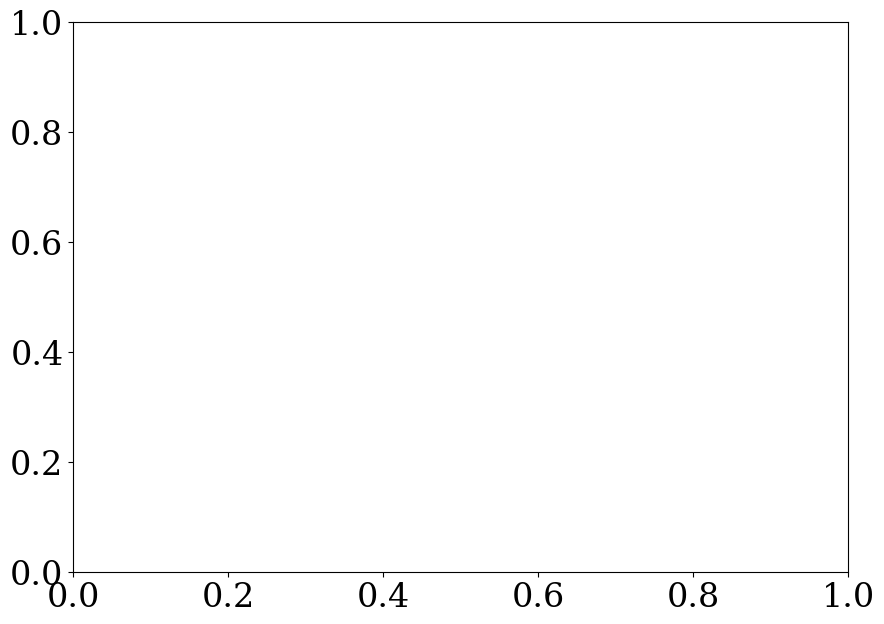

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from myfunctions_tf import load_from_directory
import scipy.fft as sf
path = "/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/2025_06_20-13_22_04-standard_amplitude_npz"

input_data, output_data = load_from_directory(path, num_signals=50, input_keys=["augmented_ifft"], output_keys=["original", "baseline", "NAA", "NAAG", "Cr"])

plt.figure(figsize=(10, 50))
for i in range(50):
    plt.subplot(6, 1, 1)
    plt.plot(sf.fftshift(sf.fft(input_data[i, :, 0] + input_data[i, :, 1] * 1j)).real, label="Augmented")
for k in range(5):
    plt.subplot(6, 1, k + 2)
    for i in range(50):
        plt.plot(output_data[i, :, k])
plt.show()
